In [67]:
import sys
import os

import numpy as np 
import matplotlib.pyplot as plt

from src.model import *
from src.dataset import MyDataset, WeakDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    plot_losses,
    plot_graphs,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

In [68]:
cfg = {
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 10000,
    "batch_size": 50,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "schedule_freq": 2500,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':100,
    'n_samples_weak':900,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_weak']\
                +cfg_dataset['n_samples_test'],
    'n_features':20,
    'n_informative':20,
    'n_targets':1,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [69]:
X, y = make_regression(**cfg_make_reg)
X = (X - X.mean(axis=0))/X.std(axis=0)
y = (y - y.mean(axis=0))/y.std(axis=0)
y = y[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=cfg_dataset["n_samples_test"])

X_weak = X_train[cfg_dataset["n_samples_train"]:]
X_train = X_train[:cfg_dataset["n_samples_train"]]
y_train = y_train[:cfg_dataset["n_samples_train"]]
train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"], device=cfg["device"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"], device=cfg["device"])
weak_loader = WeakDataset(X_weak, batch_size=512, device=cfg["device"])

with torch.no_grad():
    X_train_torch = torch.Tensor(X_train).to(cfg["device"])
    X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
    X_test_torch = torch.Tensor(X_test).to(cfg["device"])
    y_test_torch = torch.Tensor(y_test).to(cfg["device"])
    noise_test = torch.cat([X_test_torch,
                            torch.zeros(y_test.shape, device=cfg['device'])], axis=1)

In [70]:
losses = [[], [], [], [], []]
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

### Without regularization

In [11]:
for e in tqdm(range(cfg['num_epochs'])):
    for X_batch, y_batch in train_loader:
        ### Discriminator
        optimD.zero_grad()
        real = torch.cat([X_batch, y_batch], axis=1)

        with torch.no_grad():
            noise = torch.cat([X_batch,
                                  torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                 netG(noise)], axis=1)
            
        e_fake = netD(fake).mean()
        e_real = netD(real).mean()
        netD_loss = e_fake - e_real

        eps_pen = e_real ** 2
        eps_loss = eps_pen.mean()

        mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
        mixed = mix_alpha * real + (1 - mix_alpha) * fake
        mixed.requires_grad_(True)
        mixed_preds = netD(mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(real), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
        meters['netD_loss'].update(netD_total_loss.item())
        netD_total_loss.backward()
        optimD.step()

        ### Generator
        optimG.zero_grad()
        optimD.zero_grad()

        with torch.no_grad():
            noise = torch.cat([X_batch,
                               torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)

        fake = torch.cat([X_batch,
                          netG(noise)], axis=1)

        netG_pred = netD(fake) 
        netG_loss = - netG_pred.mean()

        with torch.no_grad():
            L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
            meters['netG_loss'].update(L2Loss.item())

        netG_loss_total = netG_loss
        netG_loss_total.backward()
        optimG.step()

    if not e % cfg["display_freq"]:
        with torch.no_grad():
            y_pred = netG(noise_test)
            l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

        losses[0].append(meters["netD_loss"].avg)
        losses[1].append(meters["eps_loss"].avg)
        losses[2].append(meters["netG_loss"].avg)
        losses[3].append(meters["netG_weak_loss"].avg)
        losses[4].append(l2_test)
        
    if not e%cfg["schedule_freq"]:
        schedD.step()
        schedG.step()

100% 10000/10000 [01:17<00:00, 129.30it/s]


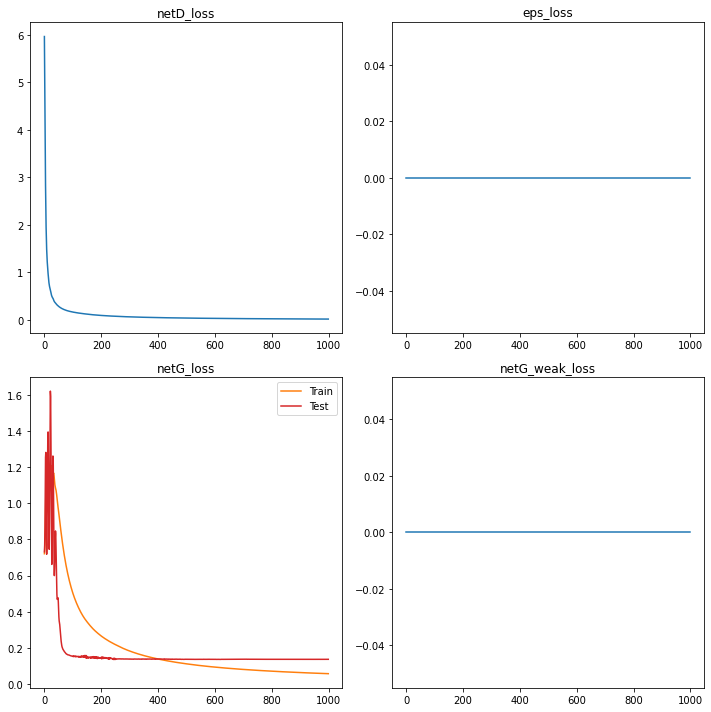

In [12]:
plot_graphs(losses, meters)

### With regularization

In [127]:
class GraphLaplacian(nn.Module):

    def __init__(self, l=1):
        super().__init__()
        self.l = l
        
    def get_L(self, X):
        with torch.no_grad():
            W = torch.exp(-torch.cdist(X, X, p=2.0)**2/(2*(self.l**2)))
            D = torch.diag(W.sum(axis=0))
        return D - W
    
    def forward(self, X, model):
        f = model(X)
        L = self.get_L(X)
        n = f.shape[0]
        return ((f.T@L@f)/(n**2)).flatten()

In [128]:
cfg = {
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 8, 32, 128],
    "num_epochs": 10000,
    "batch_size": 50,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-1,
    "display_freq": 10,
    "schedule_freq": 2500,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2
}


cfg_dataset = {
    'n_samples_train':100,
    'n_samples_weak':900,
    'n_samples_test':1000,
}

In [129]:
losses = [[], [], [], [], []]
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

LB = GraphLaplacian(l=20)

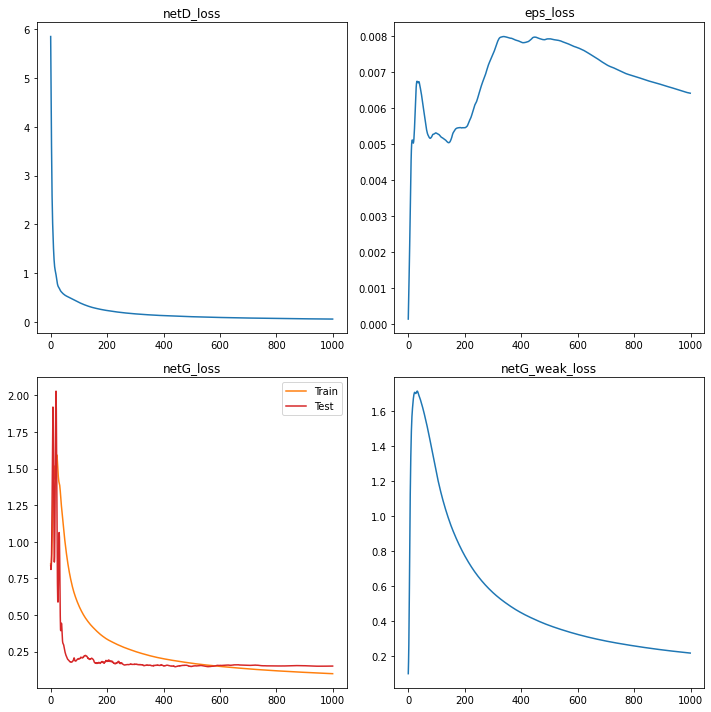

In [130]:
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        X_batch_weak = weak_loader.sample()

        ### Discriminator
        optimD.zero_grad()
        real = torch.cat([X_batch, y_batch], axis=1)

        with torch.no_grad():
            noise = torch.cat([X_batch,
                                  torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                 netG(noise)], axis=1)

            noise_weak = torch.cat([X_batch_weak,
                                torch.randn((X_batch_weak.shape[0], y_train.shape[1]),
                                device=cfg['device'])], axis=1)
            
            fake_weak = torch.cat([X_batch_weak,
                                netG(noise_weak)], axis=1)
            
        e_fake = netD(fake).mean()
        e_real = netD(real).mean()
        netD_loss = e_fake - e_real

        eps_pen = e_real ** 2
        eps_loss = eps_pen.mean()
        meters['eps_loss'].update(eps_loss.item())

        mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
        mixed = mix_alpha * real + (1 - mix_alpha) * fake
        mixed.requires_grad_(True)
        mixed_preds = netD(mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        
        grads = grads.view(len(real), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()
        
        LB_D = LB(real, netD) + LB(fake, netD) + LB(fake_weak, netD)
        
        netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss + cfg["w_weak"]*LB_D
        meters['netD_loss'].update(netD_total_loss.item())
        netD_total_loss.backward()
        optimD.step()

        ### Generator
        optimG.zero_grad()
        optimD.zero_grad()

        with torch.no_grad():
            noise = torch.cat([X_batch,
                               torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)

        fake = torch.cat([X_batch,
                          netG(noise)], axis=1)

        netG_pred = netD(fake)
        netG_loss = -(netG_pred.mean())

        with torch.no_grad():
            L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
            meters['netG_loss'].update(L2Loss.item())

        meters['netG_weak_loss'].update(LB_D.item())
        
        netG_loss_total = netG_loss
        netG_loss_total.backward()
        optimG.step()

    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netG(noise_test)
            l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

        losses[0].append(meters["netD_loss"].avg)
        losses[1].append(meters["eps_loss"].avg)
        losses[2].append(meters["netG_loss"].avg)
        losses[3].append(meters["netG_weak_loss"].avg)
        losses[4].append(l2_test)
        plot_graphs(losses, meters)
        
    if not e%cfg["schedule_freq"]:
        schedD.step()
        schedG.step()

In [66]:
losses = [[], [], [], [], []]
netG =  nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(X_train.shape[1]+y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
).to(cfg["device"])

optimG = Adam(netG.parameters(), lr=1e-3)
optimD = Adam(netD.parameters(), lr=1e-3)

meter_names = ['netG_weak_loss','eps_loss', 'netD_loss', 'netG_loss', 'grad_loss', 'netD_real_loss', 'netD_fake_loss']
meters = create_meters(meter_names)

schedG = torch.optim.lr_scheduler.ExponentialLR(optimG, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

LB = GraphLaplacian()

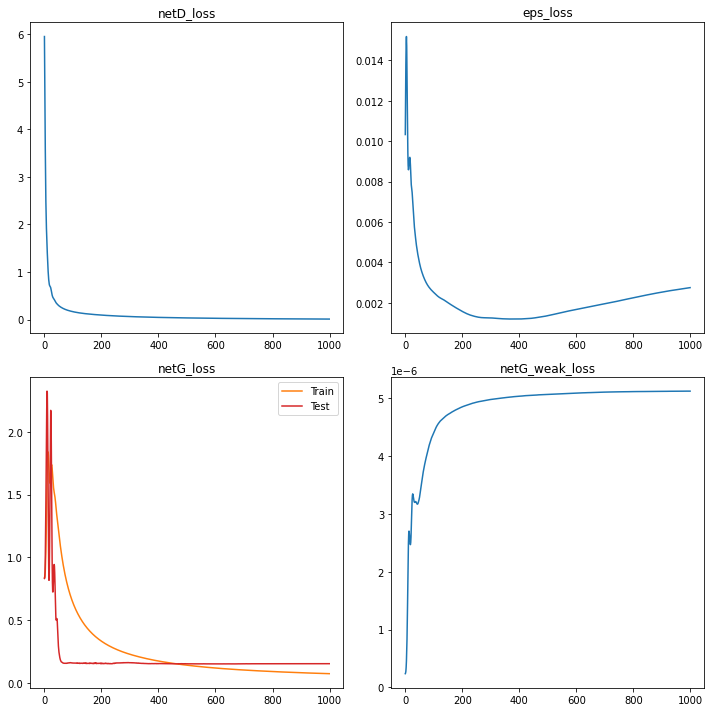

In [64]:
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        X_batch_weak = weak_loader.sample()

        ### Discriminator
        optimD.zero_grad()
        real = torch.cat([X_batch, y_batch], axis=1)

        with torch.no_grad():
            noise = torch.cat([X_batch,
                                  torch.randn(y_batch.shape, device=cfg['device'])], axis=1)
            fake = torch.cat([X_batch,
                                 netG(noise)], axis=1)

            noise_weak = torch.cat([X_batch_weak,
                                torch.zeros((X_batch_weak.shape[0], y_train.shape[1]),
                                device=cfg['device'])], axis=1)

        e_fake = netD(fake).mean()
        e_real = netD(real).mean()
        netD_loss = e_fake - e_real

        eps_pen = e_real ** 2
        eps_loss = eps_pen.mean()
        meters['eps_loss'].update(eps_loss.item())

        mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
        mixed = mix_alpha * real + (1 - mix_alpha) * fake
        mixed.requires_grad_(True)
        mixed_preds = netD(mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(real), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
        meters['netD_loss'].update(netD_total_loss.item())
        netD_total_loss.backward()
        optimD.step()

        ### Generator
        optimG.zero_grad()
        optimD.zero_grad()

        with torch.no_grad():
            noise = torch.cat([X_batch,
                               torch.zeros(y_batch.shape, device=cfg['device'])], axis=1)

        fake = torch.cat([X_batch,
                          netG(noise)], axis=1)

        netG_pred = netD(fake)
        netG_pred_weak = LB(noise_weak, netG)
        netG_loss = netG_pred_weak - netG_pred.mean()

        with torch.no_grad():
            L2Loss = ((((fake[:, X_batch.shape[1]:] - real[:, X_batch.shape[1]:])**2).sum(axis=1))**(1/2)).mean()
            meters['netG_loss'].update(L2Loss.item())

        meters['netG_weak_loss'].update(netG_pred_weak.item())
        
        netG_loss_total = netG_loss
        netG_loss_total.backward()
        optimG.step()

    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netG(noise_test)
            l2_test = (torch.sqrt((y_pred - y_test_torch)**2).sum(axis=1).mean()).item()

        losses[0].append(meters["netD_loss"].avg)
        losses[1].append(meters["eps_loss"].avg)
        losses[2].append(meters["netG_loss"].avg)
        losses[3].append(meters["netG_weak_loss"].avg)
        losses[4].append(l2_test)
        plot_graphs(losses, meters)
        
    if not e%cfg["schedule_freq"]:
        schedD.step()
        schedG.step()